<a href="https://colab.research.google.com/github/HazemmoAlsady/AWN_Graduation_Project/blob/main/assistance_type_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn xgboost -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

from xgboost import XGBClassifier
from scipy.sparse import hstack

In [ ]:
df = pd.read_excel('/content/Awnn_feature_engineering (1).xlsx')

drop_cols = [
    'name','national_id','phone','city','neighborhood','recommended_org'
]

df = df.drop(columns=drop_cols, errors='ignore')

# نحذف unknown
df = df[df['assistance_type'] != 'unknown'].reset_index(drop=True)

df['request_text'] = df['request_text'].astype(str)

print(df['assistance_type'].value_counts())

assistance_type
medical                 15296
food                    11441
financial               11332
education                7669
housing                  7494
disability_equipment     3756
Name: count, dtype: int64


In [ ]:
X_text = df['request_text']
y = df['assistance_type']

structured_features = [
    'financial_gap',
    'hardship_score',
    'income_stability',
    'family_size',
    'children_ratio',
    'economic_pressure',
    'debt_to_income_ratio',
    'remaining_income',
    'is_deficit',
    'critical_case'
]

X_structured = df[structured_features]

In [ ]:
X_text_train, X_text_test, \
X_struct_train, X_struct_test, \
y_train, y_test = train_test_split(
    X_text,
    X_structured,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),
    min_df=2
)

X_text_train_tfidf = vectorizer.fit_transform(X_text_train)
X_text_test_tfidf = vectorizer.transform(X_text_test)

In [ ]:
scaler = StandardScaler()

X_struct_train_scaled = scaler.fit_transform(X_struct_train)
X_struct_test_scaled = scaler.transform(X_struct_test)

In [ ]:
X_train_final = hstack([X_text_train_tfidf, X_struct_train_scaled])
X_test_final = hstack([X_text_test_tfidf, X_struct_test_scaled])

In [ ]:
le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_enc),
    y=y_train_enc
)

class_weight_dict = dict(enumerate(class_weights))

In [55]:
xgb = XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss',
    objective='multi:softprob'
)

xgb.fit(
    X_train_final,
    y_train_enc,
    sample_weight=[class_weight_dict[i] for i in y_train_enc]
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

Accuracy: 0.9606948587471487
Macro F1: 0.9621612242402316

Classification Report:

                      precision    recall  f1-score   support

disability_equipment       0.99      0.95      0.97       751
           education       0.98      0.95      0.97      1534
           financial       0.95      0.96      0.96      2267
                food       0.95      0.97      0.96      2288
             housing       0.97      0.95      0.96      1499
             medical       0.95      0.96      0.96      3059

            accuracy                           0.96     11398
           macro avg       0.97      0.96      0.96     11398
        weighted avg       0.96      0.96      0.96     11398



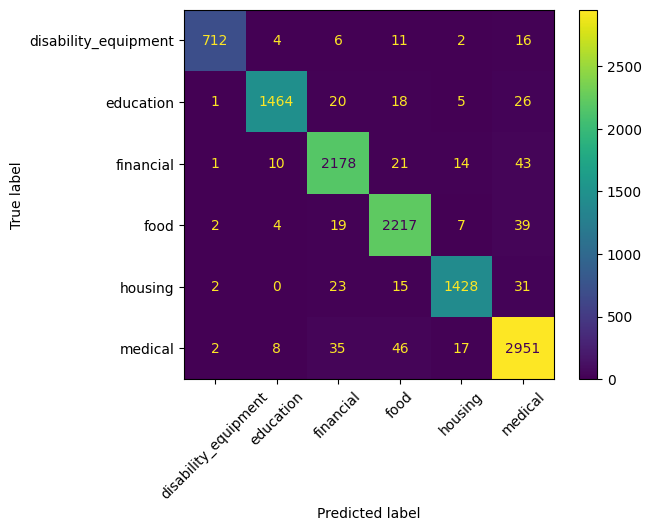

In [ ]:
y_pred = xgb.predict(X_test_final)

print("Accuracy:", accuracy_score(y_test_enc, y_pred))
print("Macro F1:", f1_score(y_test_enc, y_pred, average='macro'))

print("\nClassification Report:\n")
print(classification_report(
    y_test_enc,
    y_pred,
    target_names=le.classes_
))

ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_pred,
    display_labels=le.classes_
)

plt.xticks(rotation=45)
plt.show()

In [56]:
def predict_case(text, structured_values):

    text_vec = vectorizer.transform([str(text)])

    structured_df = pd.DataFrame(
        [structured_values],
        columns=structured_features
    )

    structured_scaled = scaler.transform(structured_df)

    final_input = hstack([text_vec, structured_scaled])

    pred = xgb.predict(final_input)

    return le.inverse_transform(pred)[0]

In [57]:
sample_index = 10

print("True label:", df['assistance_type'].iloc[sample_index])

print("Prediction:",
      predict_case(
          df['request_text'].iloc[sample_index],
          df[structured_features].iloc[sample_index].tolist()
      )
)

True label: food
Prediction: food


In [58]:

print(predict_case(
    "أنا محتاج علاج طبي بشكل عاجل",
    [4000,0.9,0.2,5,0.6,0.7,0.5,-800,1,1]
))

medical
